<a href="https://colab.research.google.com/github/Cirrusfloccus31/MiniProjets_HDDL/blob/main/MP2_HDDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-projet n° 2 – Conditional VAEs

Paul Lacotte, Ariadna Perellò, Oriane Caputo, Hugo Germain

## Qu'est ce qu'un Autoencodeur Variationnel Conditionné ?

Un Auto-Encodeur Variationnel Conditionné (CVAE) est une variante de l'auto-encodeur variationnel (VAE). Un VAE chercher à reconstruire une entrée $x$ par une sortie $\hat{x}$. Pour faire cela il est construit avec deux réseaux de neurones : un encodeur qui va de "l'espace des $x$" dans l'espace latent et un décodeur qui fait l'inverse. L'encodeur essaie d'approcher $q(z|x)$ la distribution de probabilité de $z$ (la représentation latente de $x$) sachant $x$. En fait il approche des moyennes $\mu$ et des écarts type $\sigma$ car on suppose la distribution normale. Puis une couche échantillonne la distribution de probabilité pour obternir $z$. Ensuite le décodeur approche $p(x|z)$ la distribution de probabilité de $x$ (image reconstruite) à partir de $z$. Mais si ensuite nous voulons générer de nouvelles images, nous n'avons aucun contrôle sur la classe que l'on veut générer. Dans le cas du dataset MNIST, cela signifie que nous ne pouvons pas choisir le nombre qui sera sur l'image générée. Le CVAE résout ce problème en ajoutant une condition avec un label $y$, qui sera une nombre entre 0 et 9 dans le cas du dataset FashionMNIST. Maintenant l'encodeur va calculer la distribution de probabilité de $z$ à partir de l'image d'entrée $x$ et de son label $y$ : $q(z|x,y)$. Le décodeur va essayer de reconstruite l'image $x$ à partir  de l'échantillon $z$ et de son label $y$ : $p(x|z,y)$. Pour résumer la principale différence entre un VAE et un CVAE est que les deux distribution de probabilité de l'encodeur et du décodeur sont conditionnées par le label $y$. Cela résout le problème de génération parce que, si vous voulons générer une nouvelle image d'un T-shirt (correspondant au label "0") nous pouvons utiliser le cvae et donner lui donner le label 0 et une image correspondant à un bruit gaussien en entrée. Le schéma suivant résume l'architecture générale d'un CVAE, les modifications par rapport à un CVAE sont en orange.

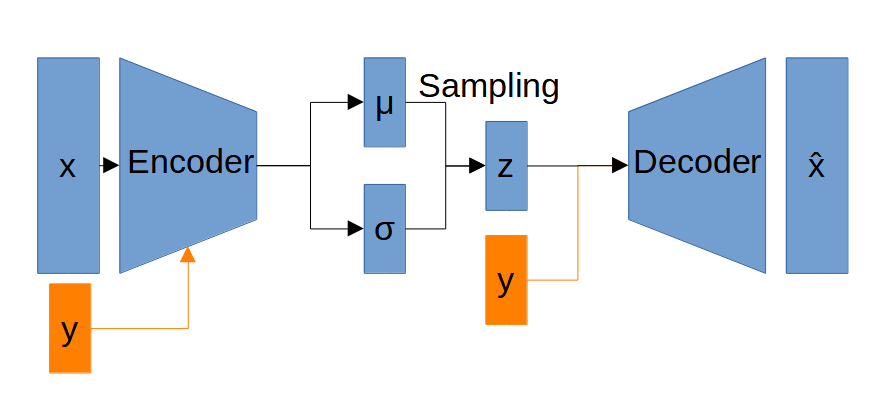

Pour nous renseigner sur les CVAE et avoir des exemples architectures nous avons visité les sites suivants :

*   https://medium.com/@sofeikov/implementing-conditional-variational-auto-encoders-cvae-from-scratch-29fcbb8cb08f
*   https://github.com/unnir/cVAE/blob/master/cvae.py
*   https://towardsdatascience.com/understanding-conditional-variational-autoencoders-cd62b4f57bf8



## Le dataset Fashion MNIST


Le dataset Fashion MNIST est un jeu de données de 70 000 images en niveaux de gris répartie sur 10 classes. Les images montrent des vêtements en basse résolution (28 x 28 pixels).
La base de données est séparée en un ensemble d'apprentissage de 60 000 images et d'un ensemble de tests de 10 000 images.

Les 10 classes sont les suivantes :
0. T-shirt
1. Pantalon
2. Pullover
3. Robe
4. Manteau
5. Sandale
6. Chemise
7. Chaussure de sport
8. Sac
9. Bottines

## Imports

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch.nn.functional as F
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
from torchvision import datasets, transforms


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device :", device)

device : cuda


## Téléchargement du dataset and Dataloader

In [ ]:
# Define the transformation
transform = transforms.ToTensor()

# Load the dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

batch_size=128
num_classes=10

#DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.9MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.70MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 17.8MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## Exploration des données

In [ ]:
#Sélection d'un batch d'image
images, labels = next(iter(train_loader))
print("Tailles des images :", images.shape) #torch.Size([128, 1, 28, 28])
print("Tailles des Labels :", labels.shape) #torch.Size([128])
print(f"Les valeurs des pixels des images sont comprises entre {images.min().item()} et {images.max().item()}")

Tailles des images : torch.Size([128, 1, 28, 28])
Tailles des Labels : torch.Size([128])
Les valeurs des pixels des images sont comprises entre 0.0 et 1.0


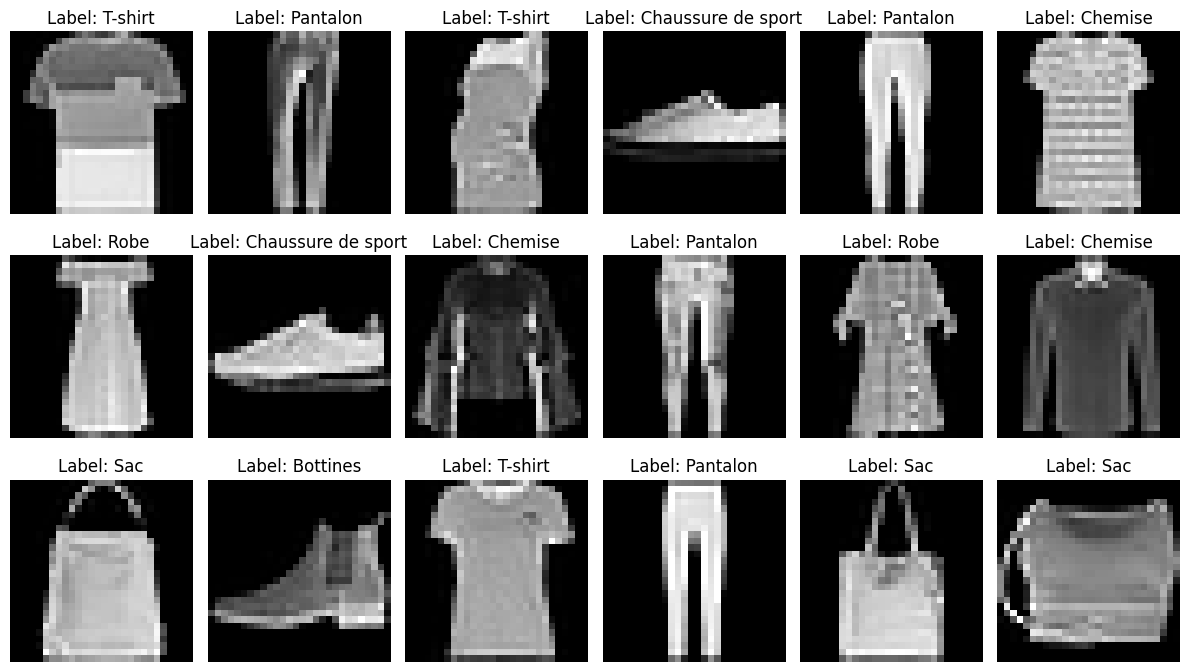

In [ ]:
# Exploration des données
fig, axs = plt.subplots(3, 6, figsize=(12, 7))
# Liste contenant les noms des classes (l'indice correspond au label)
classe_name = ["T-shirt",
               "Pantalon",
               "Pullover",
               "Robe",
               "Manteau",
               "Sandale",
               "Chemise",
               "Chaussure de sport",
               "Sac",
               "Bottines",
]

# On prend des images au hasard et on les affiche
for i in range(3):
    for j in range(6):
        image, label = train_dataset[np.random.randint(0, len(train_dataset))]
        image_numpy = image.numpy().squeeze()
        axs[i, j].imshow(image_numpy, cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(f"Label: {classe_name[label]}")
plt.tight_layout()
plt.show()

On peut déjà voir que sur les images certains objets sont déjà flous, on ne pourra pas attendre mieux du CVAE.

## Implémentation du CVAE

On implémente le CVAE comme décrit ci-dessous :
- Les entrées/sorties sont des images, on utilise donc des couches de convolution qui sont adaptées au traitement d'image.
- On choisit d'encoder le label $y$ sous la forme d'un vecteur avec uniquement des zéros sauf à la position correspondant à la classe où on met un 1 (one-hot encoding). On l'intègre dans l'encodeur en le concaténant avec l'image transformée en vecteur (flatten). On applique alors des couches denses pour obtenir les moyennes et écarts-type puis la couche d'échantillonage pour obtenir $z$.
- De même, pour le décodeur, on utilise le label $y$ en le concaténant avec le vecteur de l'espace latent $z$.
- On applique alors des couches denses puis des convolutions transposées pour obtenir la reconstruction de l'image.


In [ ]:
# Implementation du CVAE

class Encoder(nn.Module):
    def __init__(self, latent_dim=10):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim

        # Activation ReLU
        self.relu=nn.ReLU()

        # Couches de convolution, denses et batch normalisation
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1) # Output: (32, 14, 14)
        self.batch_norm1=nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # Output: (64, 7, 7)
        self.batch_norm2=nn.BatchNorm2d(64)
        self.conv3=nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # Output: (128, 4, 4)
        self.batch_norm3=nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 4 * 4 + num_classes, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)

        # Couches denses pour les moyennes et les écart-types
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

    def forward(self, x, y):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.relu(self.batch_norm2(self.conv2(x)))
        x = self.relu(self.batch_norm3(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4) # Flatten la sortie des convolutions
        y = F.one_hot(y, num_classes=num_classes) # one-hot encoding des labels
        x = torch.cat([x, y], 1) # on concatène
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim=10):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim

        # Activations ReLU et sigmoid
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # Couches de convolution, denses et batch normalisation
        self.fc1 = nn.Linear(latent_dim + num_classes, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128 * 4 * 4)
        self.convt1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1)  # Output: (64, 7, 7)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.convt2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # Output: (32, 14, 14)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.convt3 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1) # Output: (1, 28, 28)

    def forward(self, z, y):
        y = F.one_hot(y, num_classes=num_classes) # one-hot encoding des labels
        x = torch.cat([z, y], 1) # on concatène
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = x.view(-1, 128, 4, 4) # Reshape à (128, 4, 4) pour la partie convolutionnelle du décodeur
        x = self.relu(self.batch_norm1(self.convt1(x)))
        x = self.relu(self.batch_norm2(self.convt2(x)))
        x = self.convt3(x)
        x = self.sigmoid(x) # Activation sigmoid pour avoir des des valeurs dans [0,1]
        return x

class CVAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar) # On récupère l'écart-type
        eps = torch.randn_like(std) # eps ~ N(0,1)
        return mu + eps * std # ~ N(mu, std*Id)

    def forward(self, x, y):
        mu, logvar = self.encoder(x, y) # On passe dans l'encodeur
        z = self.sample(mu, logvar) # On tire aléatoirement un z
        return self.decoder(z, y), mu, logvar # On passe dans le décodeur

##Fonctions côut

In [ ]:
# Loss function for the CVAE
def loss_function_mse(recon_x, x):
    """Mean Square Error loss"""
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    return MSE
def loss_function_kld(mu, logvar):
    """Kullback–Leibler divergence (KLD)"""
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # formule de la KLD pour une loi normale
    return KLD

## Entraînement du modèle

In [ ]:
def train(model, optimizer, epochs=10):
    model.to(device) #On met le modèle sur le CPU ou le GPU
    #Listes pour garder en mémoire les loss
    train_loss_mse = []
    train_loss_kld = []
    train_loss = []
    test_loss_mse = []
    test_loss_kld = []
    test_loss = []
    pbar_epochs = tqdm(range(1, epochs + 1))
    for epoch in pbar_epochs:
        pbar_epochs.set_description(f"Epoch {epoch}/{epochs}")
        model.train()
        running_loss = 0.0
        running_loss_mse = 0.0
        running_loss_kld = 0.0
        for (image, label) in train_loader:
            image, label = image.to(device), label.to(device)
            optimizer.zero_grad()
            recon_image, mu, logvar = model(image, label)
            loss_mse = loss_function_mse(recon_image, image)
            loss_kld = loss_function_kld(mu, logvar)
            loss = loss_mse + beta*loss_kld
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_loss_mse += loss_mse.item()
            running_loss_kld += loss_kld.item()

        train_loss.append(running_loss / len(train_loader.dataset))
        train_loss_mse.append(running_loss_mse / len(train_loader.dataset))
        train_loss_kld.append(running_loss_kld / len(train_loader.dataset))

        model.eval()
        running_loss = 0.0
        running_loss_mse = 0.0
        running_loss_kld = 0.0
        for (image, label) in test_loader:
            image, label = image.to(device), label.to(device)
            with torch.no_grad():
                recon_image, mu, logvar = model(image, label)
            loss_mse = loss_function_mse(recon_image, image)
            loss_kld = loss_function_kld(mu, logvar)
            loss = loss_mse + beta*loss_kld

            running_loss += loss.item()
            running_loss_mse += loss_mse.item()
            running_loss_kld += loss_kld.item()

        test_loss.append(running_loss / len(test_loader.dataset))
        test_loss_mse.append(running_loss_mse / len(test_loader.dataset))
        test_loss_kld.append(running_loss_kld / len(test_loader.dataset))
    return train_loss, train_loss_mse, train_loss_kld, test_loss, test_loss_mse, test_loss_kld

On entraine le modèle sur différentes valeur de beta. On veut voir l'influence de beta sur l'entrainement, notamment au niveau de l'erreur de reconstruction. Pour générer des images, on pourra tester ces différents modèles.

In [ ]:
#Hyperparmètres
lr = 0.0001
epochs = 100
latent_dim = 2
betas = [0.001, 0.01, 0.1, 1, 10]

#On lance plusieurs entrainements pour ajuster la valeur de beta
cvaes = []
losses = []
pbar_betas = tqdm(betas)
for beta in pbar_betas:
    pbar_betas.set_description(f"Training for beta = {beta}")
    cvae = CVAE(latent_dim=latent_dim)
    adam = optim.Adam(cvae.parameters(), lr = lr)
    train_loss, train_loss_mse, train_loss_kld, test_loss, test_loss_mse, test_loss_kld = train(cvae, adam, epochs=epochs)
    cvaes.append(cvae)
    losses.append((train_loss, train_loss_mse, train_loss_kld, test_loss, test_loss_mse, test_loss_kld))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Pour sauvegarder les poids des modèles si besoin
for i in range(len(cvaes)):
    torch.save(cvaes[i].state_dict(), f"cvae{betas[i]}.pth")

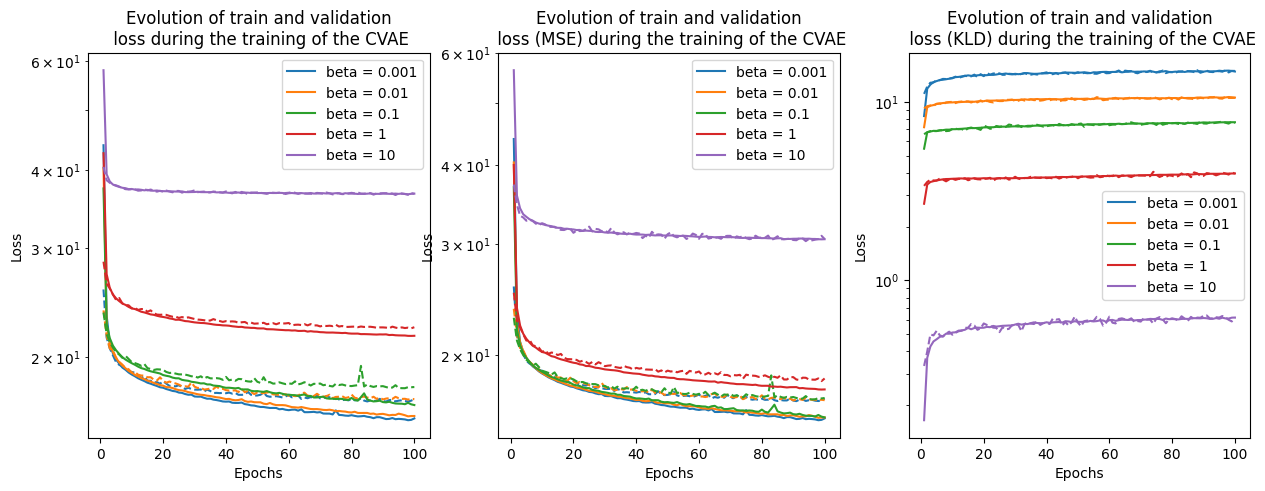

In [ ]:
# Visualistion de la loss durant l'entrainement
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15,5))
xaxis_epochs = np.arange(1, epochs + 1)
for i in range(len(betas)):
    train_loss, train_loss_mse, train_loss_kld, test_loss, test_loss_mse, test_loss_kld = losses[i]
    ax1.semilogy(xaxis_epochs, train_loss, label = f"beta = {betas[i]}", color = f"C{i}")
    ax1.semilogy(xaxis_epochs, test_loss, color = f"C{i}", linestyle="dashed")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.set_title("Evolution of train and validation\n loss during the training of the CVAE")
    ax1.legend()
    ax2.semilogy(xaxis_epochs, train_loss_mse, label = f"beta = {betas[i]}", color = f"C{i}")
    ax2.semilogy(xaxis_epochs, test_loss_mse, color = f"C{i}", linestyle="dashed")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.set_title("Evolution of train and validation\n loss (MSE) during the training of the CVAE")
    ax2.legend()
    ax3.semilogy(xaxis_epochs, train_loss_kld, label = f"beta = {betas[i]}", color = f"C{i}")
    ax3.semilogy(xaxis_epochs, test_loss_kld, color = f"C{i}", linestyle="dashed")
    ax3.set_xlabel("Epochs")
    ax3.set_ylabel("Loss")
    ax3.set_title("Evolution of train and validation\n loss (KLD) during the training of the CVAE")
    ax3.legend()
plt.show()

Ci-dessous, les courbes de la loss totale, de la MSE et de la KLD. On voit que des valeurs de beta plus faibles impliquent une MSE plus faible c'est à dire a priori une meilleure reconstruction des images.

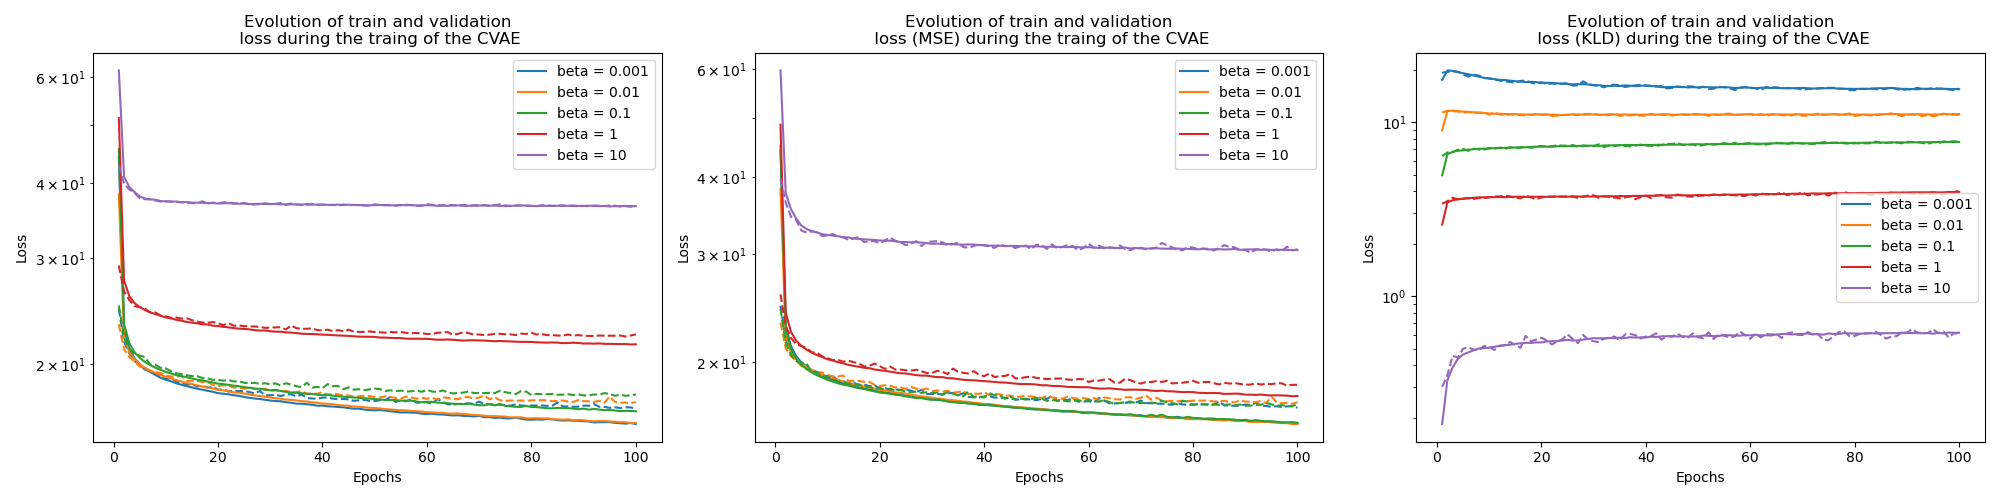

## Évaluation du réseau

In [ ]:
# Vous pouvez charger les poids de réseaux pré-entrainés
cvaes = []
latent_dim = 2
betas = [0.001, 0.01, 0.1, 1, 10]

for beta in betas:
    cvae = CVAE(latent_dim=latent_dim)
    cvae.load_state_dict(torch.load(f"weights/mp2/cvae{beta}.pth", weights_only=True))
    cvae.to(device)
    cvae.eval()
    cvaes.append(cvae)

In [ ]:
def image_comparison(original_images, reconstructions, n_images=6):
    """Plot les images originales et les reconstructions pour les différents
    modèles/beta

    Args:
        original_image (torch.Tensor): Images originales
        reconstructions (list of torch.Tensor): Images reconstruites
    """
    fig, ax = plt.subplots(len(list(reconstructions.keys())) + 1, n_images, figsize=(20, 15))

    for i in range(n_images):
        # Plot des images originales
        ax[0, i].imshow(original_images[i], cmap='gray')
        ax[0, i].axis('off')
        ax[0, 0].set_title('Original')

        for j, (beta, reconstruction) in enumerate(reconstructions.items()):
            # Images reconstruites
            ax[j + 1 , i].imshow(reconstructions[beta][i], cmap='gray')
            ax[j + 1, i].axis('off')
            ax[j + 1, 0].set_title(f'Reconstruction\n modèle avec beta = {beta}')

    plt.tight_layout()
    plt.show()

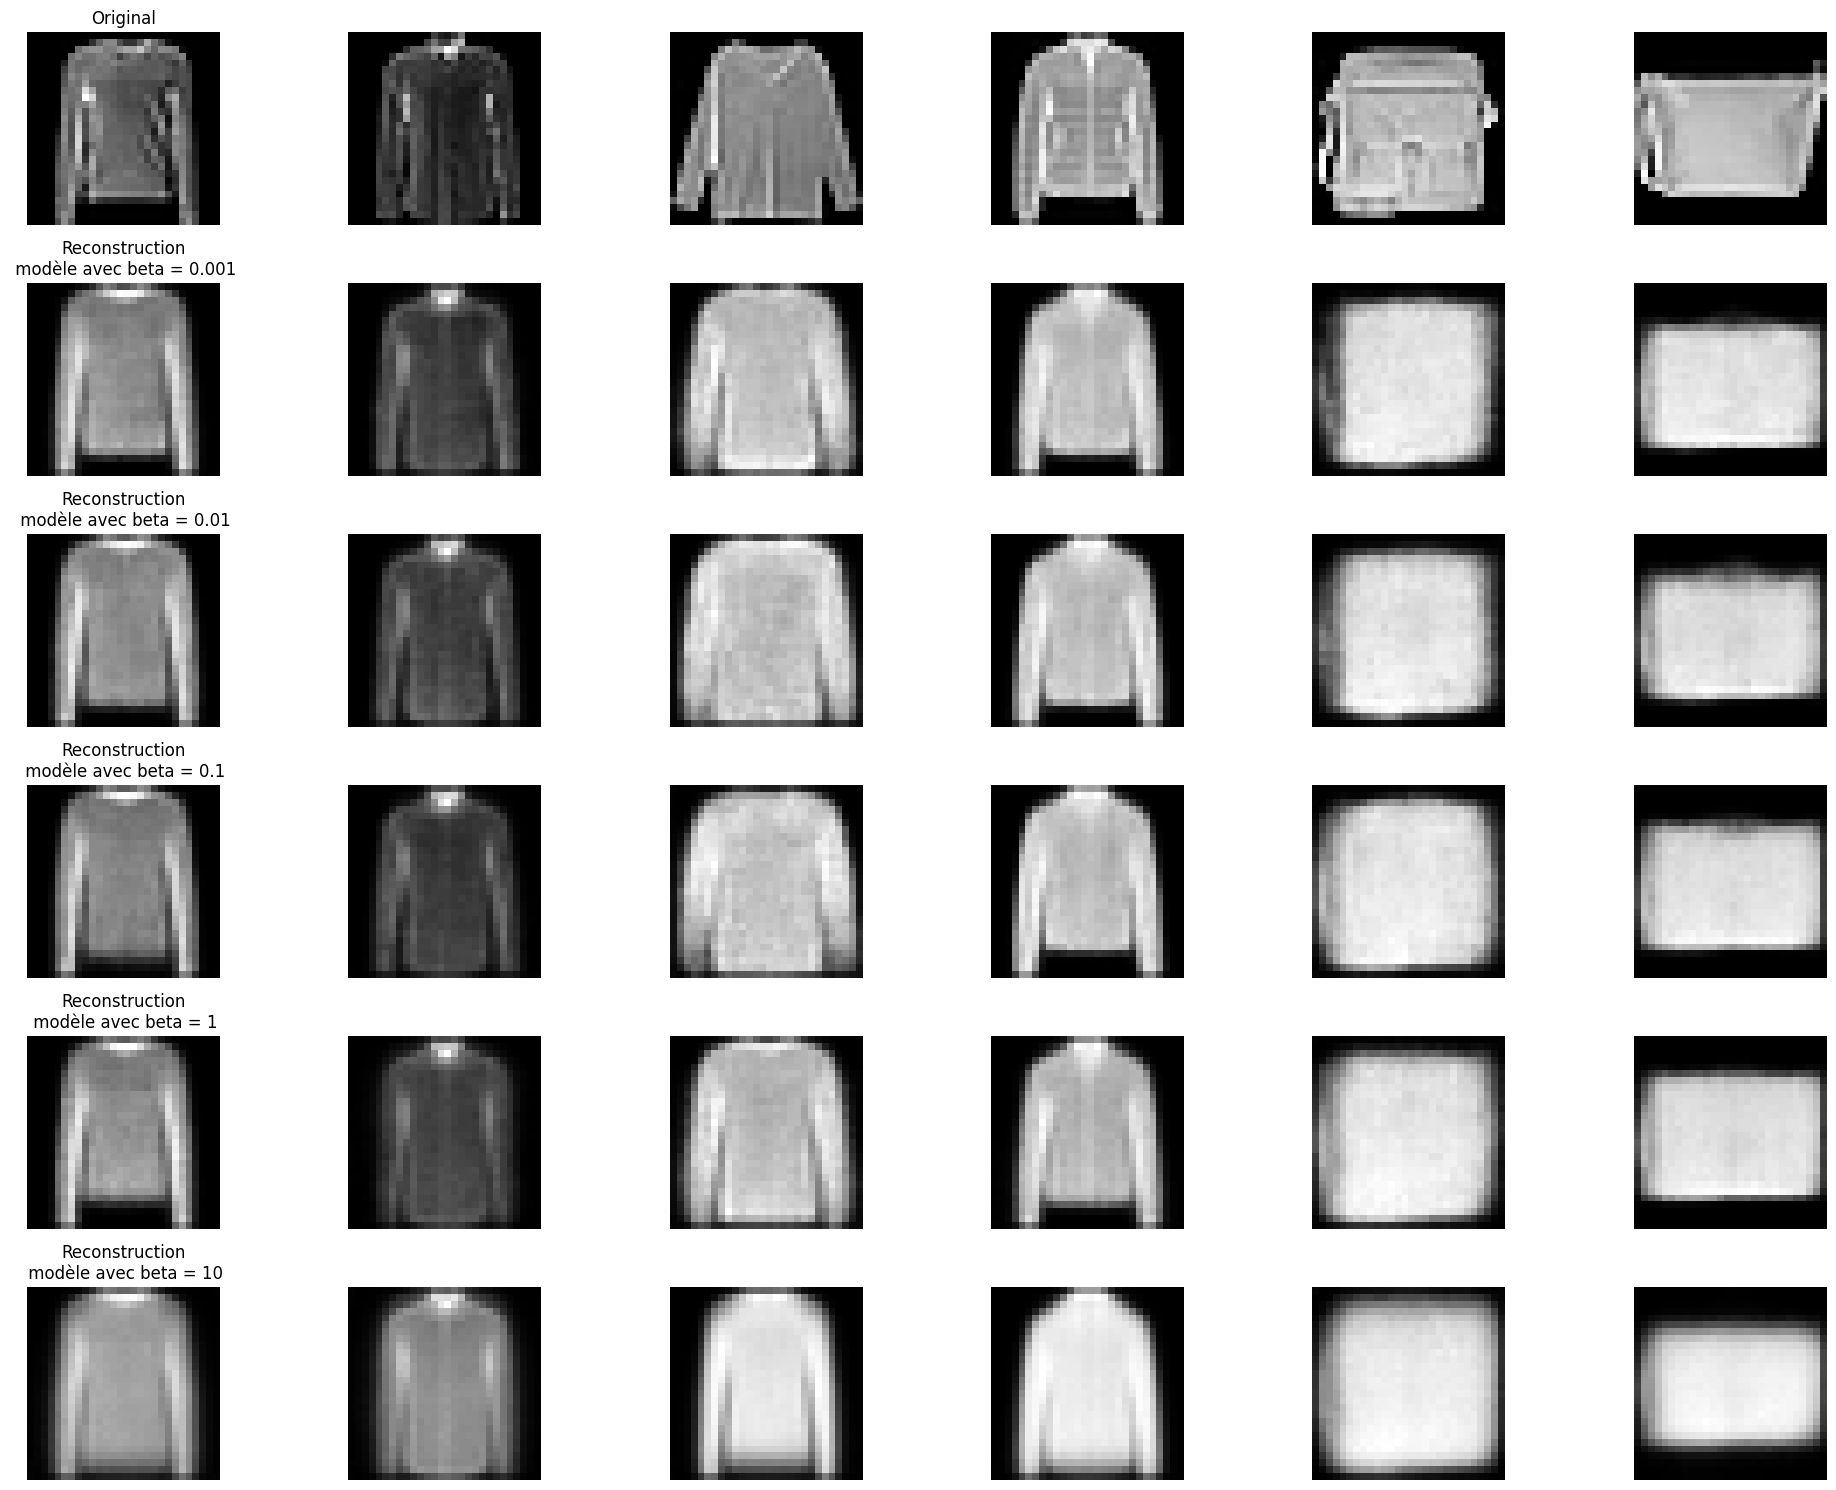

In [ ]:
# Selection d'un batch aléatoire du dataset de test
iter_test_loader = iter(test_loader)
for i in range(np.random.randint(1, len(test_loader))):
    random_images, random_labels = next(iter_test_loader)


recons_all_models = {}
for i, cvae in enumerate(cvaes):
# Générer les reconstructions
    recons, _, _ = cvae(random_images.to(device), random_labels.to(device))
    recons_all_models[betas[i]] = recons = recons.detach().cpu().numpy().squeeze()

# Reshape pour plot
random_images = random_images.cpu().numpy().squeeze()


# Plot des images originales et des leurs reconstructions
image_comparison(random_images, recons_all_models)

On ne voit pas énormément de différences visuelles, sauf pour beta = 10 où les images sont vraiment plus "floues". On testera différents modèles entrainés avec différentes valeurs de beta pour générer des images.

## Visualisation de l'espace latent

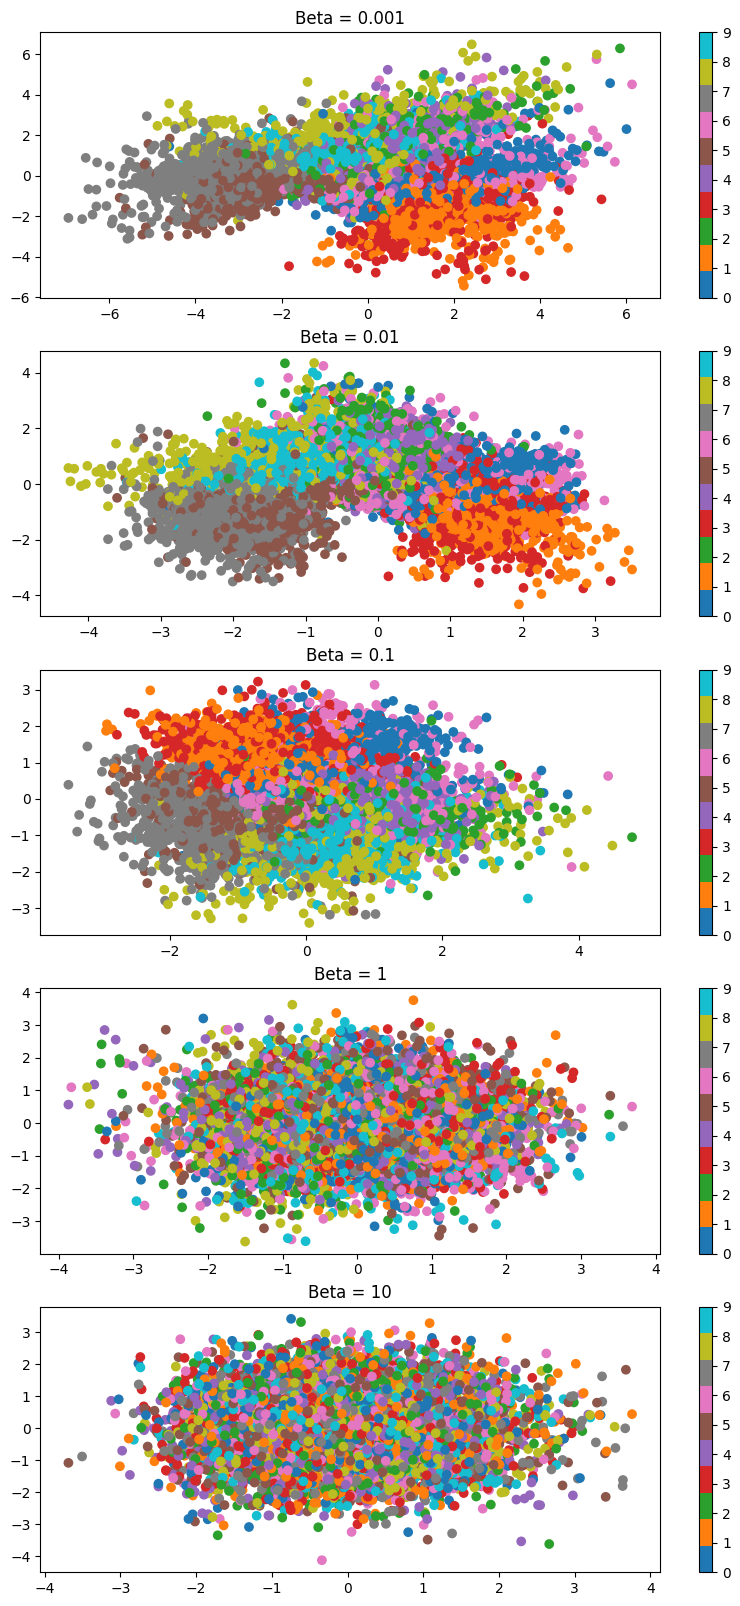

In [ ]:
#Pour visualiser l'espace latent on effectue une analyse en composantes
#principales et on projette sur le plan constitué des deux premières composantes principales

colormap = mpl.color_sequences['tab10']

fig, axs = plt.subplots(len(betas),1, figsize=(10,20))
ax = axs.flatten()
for j in range(len(betas)):
    pca = PCA(n_components=2)
    cvaes[j].eval()
    z_stocked = []
    label_stocked = []
    color = []
    for (image, label) in test_loader:
        image, label = image.to(device), label.to(device)
        with torch.no_grad():
            mu, log_var = cvaes[j].encoder(image, label)
            z = cvaes[j].sample(mu, log_var)
        for i in range(z.shape[0]):
            z_stocked.append(z[i,:].cpu().numpy())
            label_stocked.append(label[i].cpu().numpy())
            color.append(label_stocked[-1])

    pca.fit(z_stocked)
    z_pca = pca.fit_transform(z_stocked)
    plot = ax[j].scatter(z_pca[:,0], z_pca[:,1], c = color, cmap="tab10")
    ax[j].set_title(f"Beta = {betas[j]}")
    fig.colorbar(plot, ax = ax[j])
plt.show()

La visualisation de l'espace latent permet de voir l'effet de beta sur la représentation latente des images par le réseau. Plus beta est grand, moins l'espace latent s'organise par classe d'objet via des clusters.

##Génération de nouvelles images

In [ ]:
# On choisit le meilleur modèle (possibilité de changer la valeur de beta)
beta = 1
# Avec beta=1 on obtient des images correctes pour un espace latent de dimension 2
# malgré le fait que l'erreur quadratique moyenne soit un peu plus importante que pour des
# valeurs de beta plus petites
cvae = cvaes[betas.index(beta)]

In [ ]:
# Generation de 5 nouvelles images pour chaque classe
cvae.eval()
new_images = {}
for i in range(num_classes):
    images = []
    cond = torch.tensor([i]).to(device)
    for j in range(5):
        with torch.no_grad():
            x_new, _, _ = cvae(torch.randn((1,1,28,28)).to(device), cond)
        x_new = x_new.cpu().numpy().squeeze()
        images.append(x_new)
    new_images[i] = images

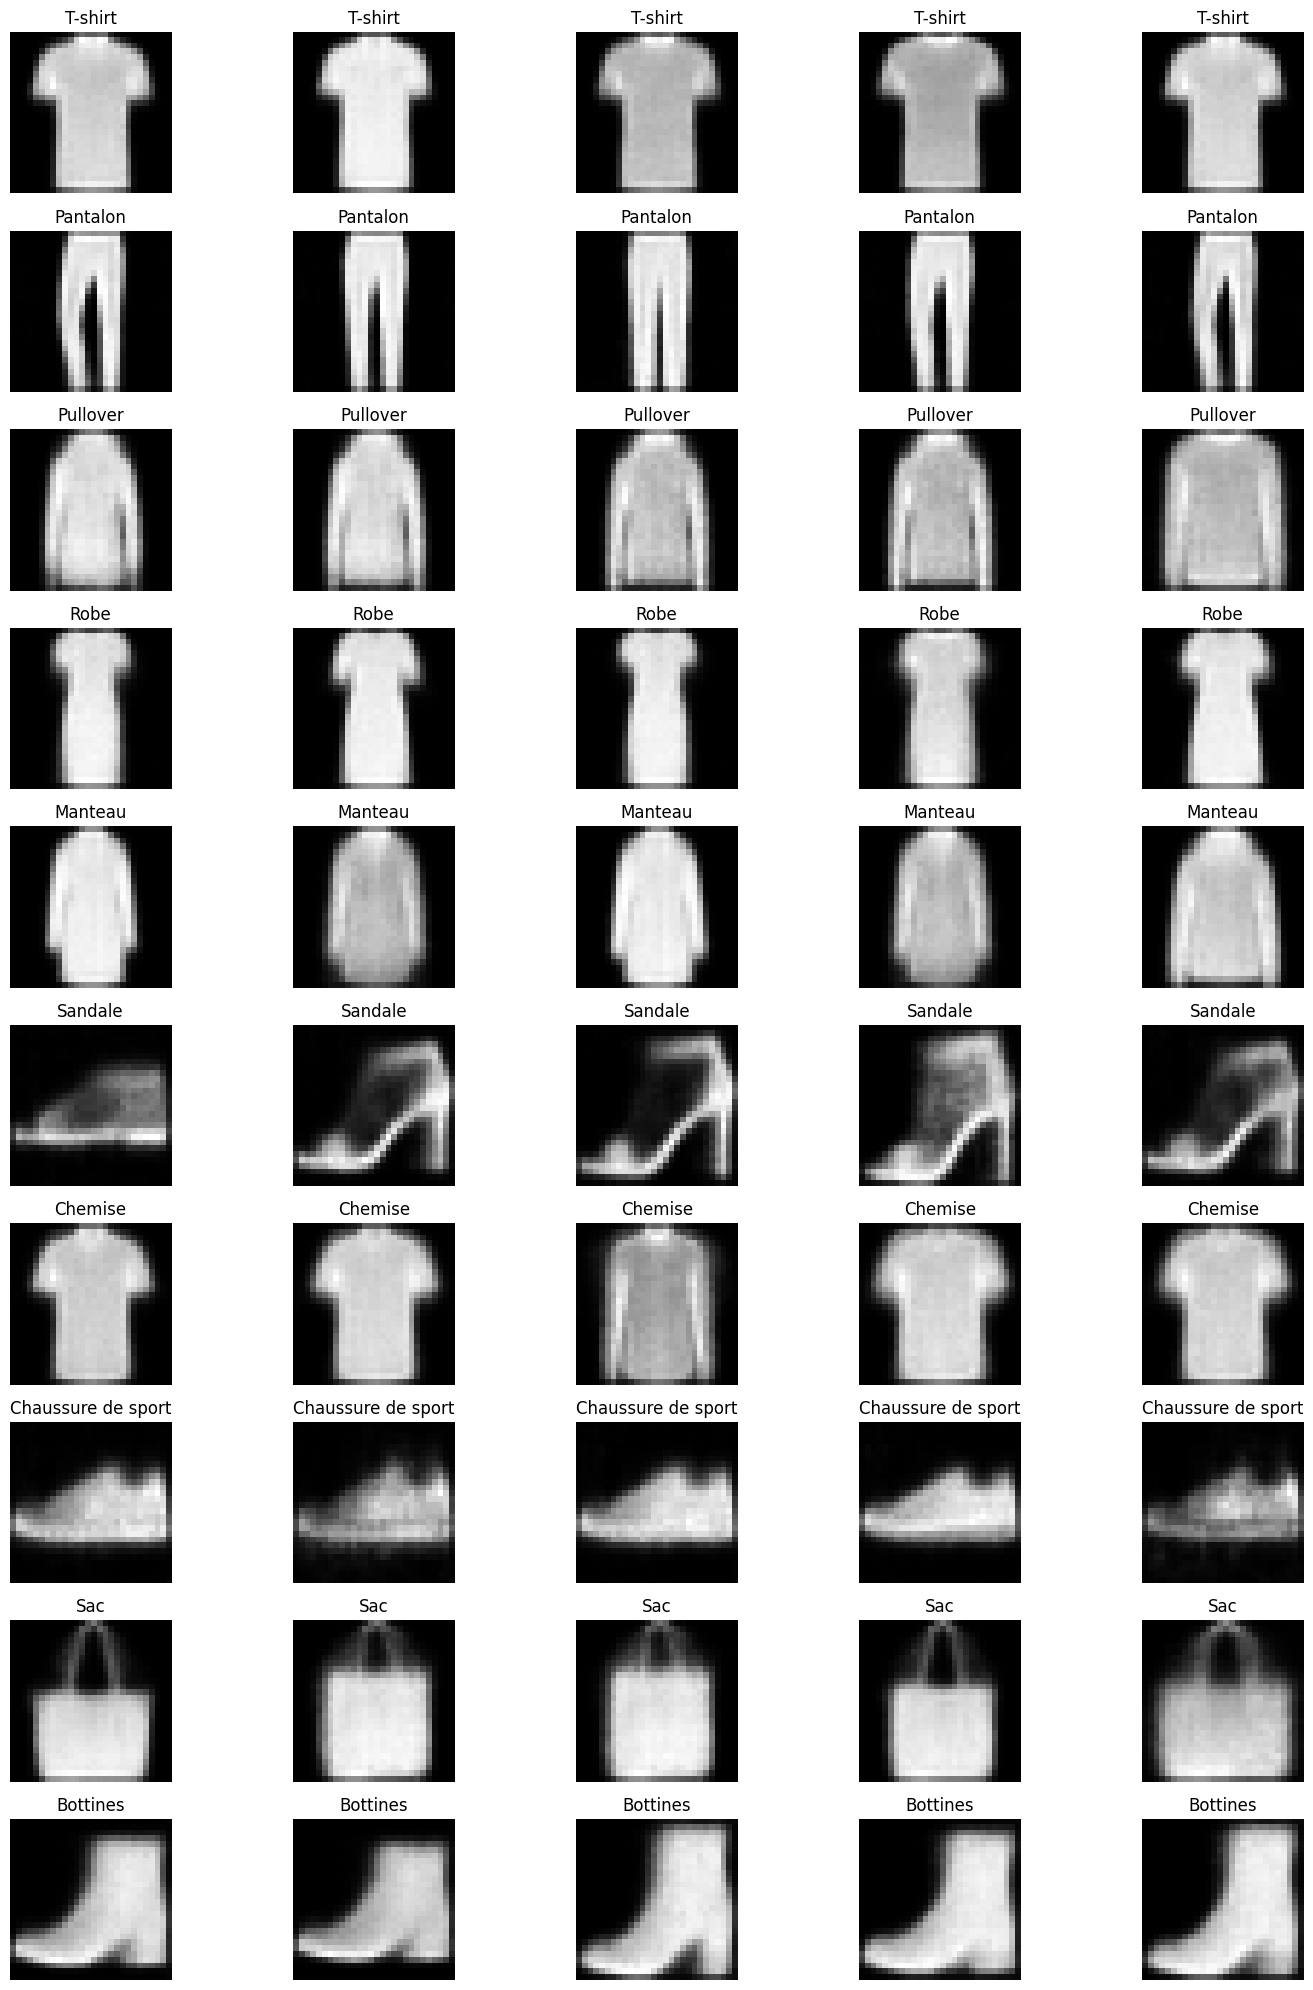

In [ ]:
fig, axs = plt.subplots(len(new_images.keys()), 5, figsize=(15, 20))

for i in new_images:
    for j in range(5):
        axs[i,j].imshow(new_images[i][j], cmap="gray")
        axs[i,j].axis("off")
        axs[i,j].set_title(classe_name[i])
plt.tight_layout()

##Conclusion

Lors de ce projet, nous avons entrainé un CVAE sur le dataset Fashion MNIST dans le but de générer de nouvelles images. Nous avons testé différentes valeurs du paramètre beta et de la dimension de l'espace latent. Dans tous les cas les images restent un peu "floues" et parfois les classes se mélangent un peu. C'est assez normal car certaines classes sont assez proches visuellement et les images sont assez complexes (par rapport à MNIST par exemple). Nous avons noté que plus la dimension de l'espace latent est grande plus beta doit être important pour générer des images réalistes (non montré dans ce notebook). Finalement nous obtenons 5 nouvelles images par classe générées à partir d'un bruit gaussien. Par cette génération nous prouvons que le conditionnement de notre réseau fonctionne car nous obtenons bien des images correspondants aux bonnes classes.